In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img, save_img
import numpy as np
import pandas as pd
import os
import seaborn as sns
from functools import partial
sns.set_context('notebook')
sns.set_style('white')
import matplotlib.pyplot as plt

# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# # session = tf.compat.v1.Session(config=config)
# session = tf.compat.v1.InteractiveSession(config=config)


# config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# config.gpu_options.per_process_gpu_memory_fraction = 0.2
# config.gpu_options.allow_growth = True


Test GPU TensorFLow

In [2]:
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [15]:
my_dir = os.getcwd()  # grabs current work dir
all_file_paths = os.listdir()  # grabs all items in current work dir

data_path = [data for data in all_file_paths if 'traindata' in data.lower()]  # searches for data folder and retrieves

picture_folder_path = os.path.join(my_dir, data_path[0])  # joins data folder and current work dir to get picture path
all_pictures = os.listdir(picture_folder_path)  # list of pictures names in folder

picture_complete_path = [os.path.join(picture_folder_path, pic) for pic in
                         all_pictures]  # complete path to each picture

img_1 = load_img(picture_complete_path[0])
print("FIRST IMAGE DETAILS:", "\nClass: ", type(img_1), "\nFile Format: ", img_1.format,
      "\nImage type: ", img_1.mode, '\nImage Size:', img_1.size)
print()

# grayscale_message = '*' * 15 + ' Gray-scaling Images ' + '*' * 15
Color_message = '*' * 15 + ' IMPORTING RGB Images ' + '*' * 15

print(Color_message)
# grey_scale_photos = [load_img(photo, color_mode='grayscale') for photo in picture_complete_path]
rgb_scale_photos = [load_img(photo, color_mode='rgb', target_size=(240, 240)) for photo in picture_complete_path] # RGB

# convert all images to grayscale

# print()

array_message = '*' * 15 + ' Converting Images to Arrays ' + '*' * 15
print(array_message)

# convert all grayscale images to arrays for ML
# array_photo_list = [img_to_array(photo) for photo in grey_scale_photos]
array_photo_list = [img_to_array(photo) for photo in rgb_scale_photos] # RGB


X_train_all = np.asarray(array_photo_list)
X_train_all[:, :,:,0] /= 255.0  # normalizes images

# del rgb_scale_photos, array_photo_list


FIRST IMAGE DETAILS: 
Class:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 
File Format:  JPEG 
Image type:  RGB 
Image Size: (640, 480)

***************IMPORTING RGB Images ***************
*************** Converting Images to Arrays ***************


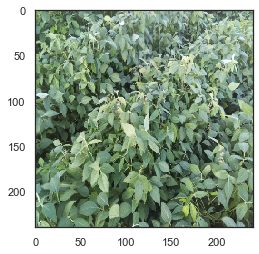

(240, 240, 3)

In [33]:
# plt.imshow(X_train_all[0][:,:,0],cmap='gray')
plt.imshow(array_photo_list[0][:,:,:].astype(np.uint8))   #OK??????
plt.show()


In [34]:
# read in CSV as pandas DF
df_y = pd.read_csv('TrainAnnotations.csv')

# strip annotation column and convert to numpy
Y_train_all = df_y['annotation'].to_numpy()

# index position describes numeric values
y_labels = ['No Wilting', 'Leaflets folding inward at secondary pulvinus, no turgor loss in leaflets or petioles',
            'Slight leaflet or petiole turgor loss in upper canopy', 'Moderate turgor loss in upper canopy',
            'Severe turgor loss throughout canopy']


<center>  Histogram of Underlying Y Label Distribution </center>

<center> Highly unbalanced </center>

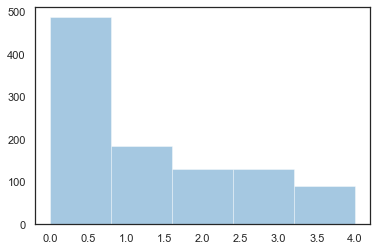

In [35]:
df_y.describe()
sns.distplot(Y_train_all, kde=False, bins=5)
plt.show()


In [40]:
model = keras.models.Sequential([keras.layers.Conv2D(filters=64, kernel_size=11, padding='SAME', input_shape=X_train_all.shape[1:]),
                                 keras.layers.MaxPooling2D(pool_size=2),
                                 keras.layers.Conv2D(filters=128, padding='SAME', kernel_size=5),
#                                  keras.layers.Conv2D(filters=128, kernel_size=3),
                                 keras.layers.MaxPooling2D(pool_size=2),
                                 keras.layers.Conv2D(filters=256, padding='SAME', kernel_size=3),
                                 keras.layers.MaxPooling2D(pool_size=2),
#                                  keras.layers.Conv2D(filters=256, kernel_size=3),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(units=16, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(units=8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(units=5, activation='softmax')
                                 ])

In [8]:
# DefaultConv2D = partial(keras.layers.Conv2D,kernel_size=3, activation='relu', padding="SAME")

# model = keras.models.Sequential([
#     DefaultConv2D(filters=64, kernel_size=11, input_shape=[320,240, 3]),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=128),
#     DefaultConv2D(filters=128),
#     keras.layers.MaxPooling2D(pool_size=2),
#     DefaultConv2D(filters=256),
#     keras.layers.MaxPooling2D(pool_size=2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(units=64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=32, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(units=10, activation='softmax'),
#     ])

In [41]:
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 240, 240, 64)      23296     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 120, 120, 128)     204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 230400)           

In [ ]:
history = model.fit(X_train_all, Y_train_all, epochs=10, validation_split=0.15, batch_size=64)

Train on 871 samples, validate on 154 samples
Epoch 1/10


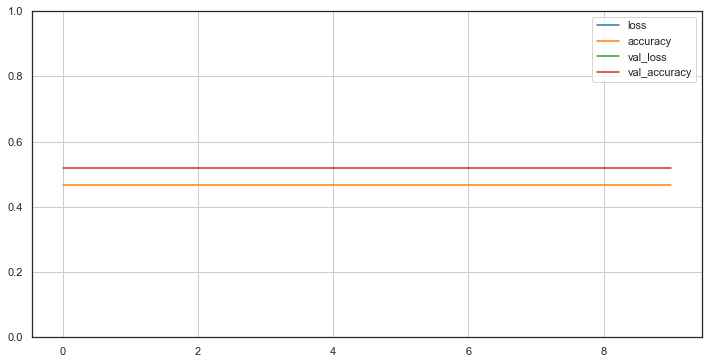

In [15]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()